# Projet numérique: Equations Différentielles

## Partie une: Schéma à pas constant

### Euler explicite

On commence par nous demandez d'écrire une fonction solve_euler_explicit qui prend en arguments:
 1. une fonction $f$
 2. un réel $x_{0}$
 3. un réel positif $dt$
 4. un réel $t_{f}$
 5. éventuellement un réel $t_{0}$, pris égal à $0$ si il n'est pas précisé.
 
Le but de cette fonction est de calculer une solution approchée de $x' = f(x,t)$ sur $[t_{0}, t_{f}[$ calculée à l'aide du schéma d'Euler explicite.

Cette fonction doit renvoyer deux vecteurs: un vecteur des temps $(t_{0}, t_{0}+dt, t_{0}+2dt, ...)$ qui contient l'ensemble des éléments de $\{ t_{0} + ndt, n \geq 0 \} \cap [t_{0}, t_{f}]$ dans l'ordre croissant; et un vecteur de valeurs qui à la $j^{ième}$ case contient la valeur approchée de $x$ (valeur qu'on nommera $x^{j}$) au temps $t_{0} + jdt$ (temps qu'on écrira souvent $t_{j}$).

In [118]:
import numpy as np

def time_range(start, end, step):
    '''Fait la même chose qu'un itérateur range, mais peut prendre un pas non entier.'''
    if end < start:
        dt = -dt
    acc = start
    while acc < end:
        yield acc
        acc += step

def solve_euler_explicit(f, x0, dt, tf, t0 = 0):
    '''Renvoie une aproximation de f entre t0 et tf évaluée à des temps séparées de dt. Utilise la méthode d'Euler explicite.'''
    times = np.array([ t for t in time_range(t0, tf, dt)])
    n = times.shape[0]
    values = np.zeros((n, ))
    values[0] = x0
    for i in range(1, n):
        values[i] = values[i - 1] + dt * f(times[i - 1], values[i - 1])
    return times, values

### Les outils de tests

On implémente ensuite trois équations différentielles dont on connaît la solution:
- $x'(t) = x(t)$ où la solution est $x(t) = exp(t)$
- $x'(t) = -sin(t)$ où la solution est $x(t) = cos(t)$
- $x'(t) = -2t \cdot x(t)$ où la solution est $x(t) = e^{-t^{2}}$

Ces équations sont implémentées avec leur solution dans une classe Pb_Cauchy, avec un set de conditions intiales et un nom de problème qui sera utile plus tard.

In [119]:
from math import exp, cos, sin

class Pb_Cauchy():
    
    def __init__(self, name, eq, sol, tf, t0 = 0):
        self.eq = eq
        self.sol = sol
        self.x0 = sol(t0)
        self.t0 = t0
        self.tf = tf
        self.name = name

PB_exp = Pb_Cauchy('Exp', lambda t, x : x, exp, 1)
PB_cos = Pb_Cauchy('Cos', lambda t, x : - sin(t), cos, 1)
PB_gss = Pb_Cauchy('Gausienne', lambda t, x : -2 * t * x, lambda t : exp(-(t**2)), 1)

On code ensuite un programme qui nous permet de tester les performances d'un solveur sur un problème de Cauchy donné en affichant la solution exacte et la solution approchée sur le même graphique.

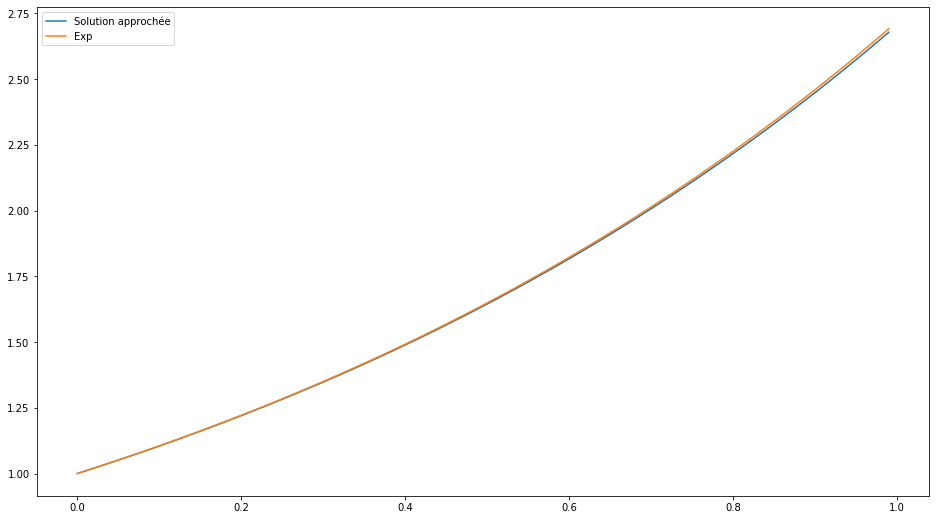

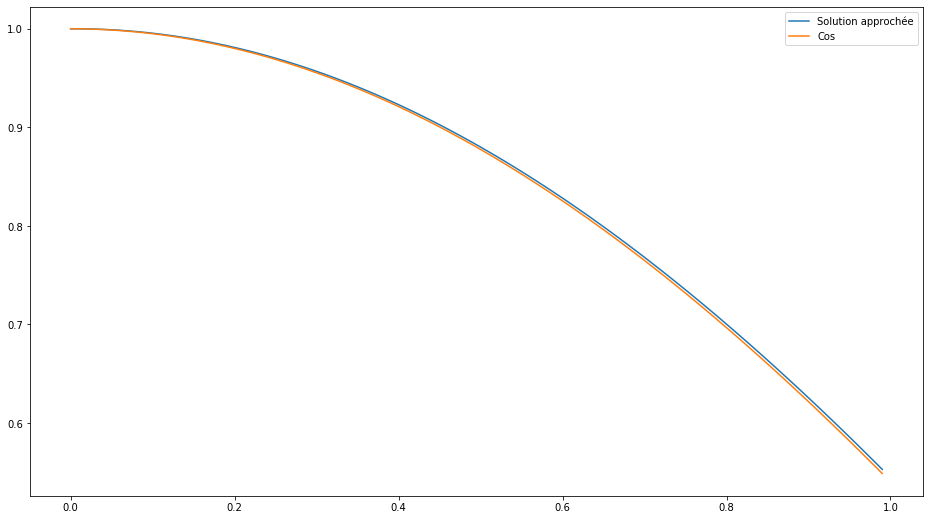

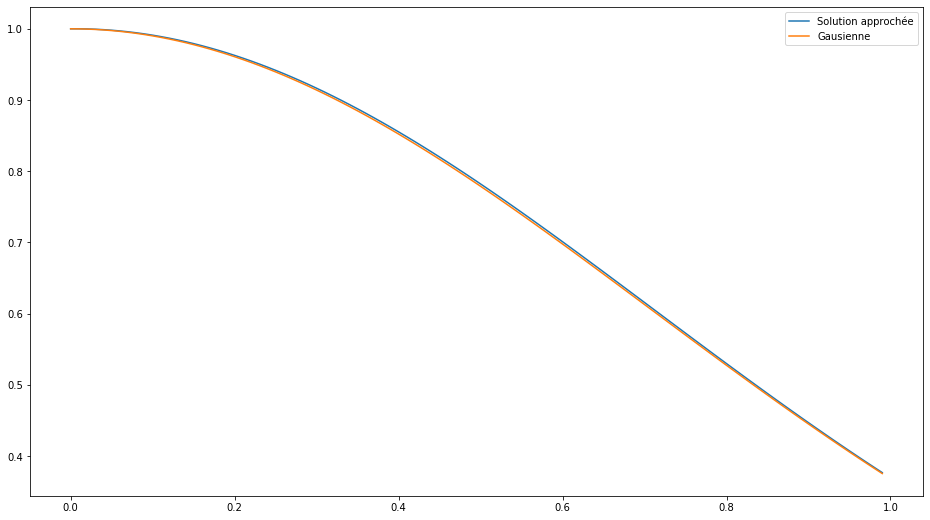

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline

def graph_multiple(abscisses, ord_list, name_list = [], log_scale = False):
    plt.rcParams['figure.figsize'] = [16, 9]
    for i in range(len(ord_list)):
        try:
            name = name_list[i]
        except:
            name = None
        plt.plot(abscisses, ord_list[i], label = name)
    if log_scale:
        plt.xscale('log')
    #plt.xlabel(x_label) retiré car le label ne se lit pas bien sur les grandes figures
    #plt.ylabel(y_label)
    plt.legend()
    plt.show()

def test_solveur(solveur, pb, dt):
    times, values = solveur(pb.eq, pb.x0, dt, pb.tf, pb.t0)
    true_values = []
    for t in times:
        true_values.append(pb.sol(t))
    graph_multiple(times, [values, true_values], ['Solution approchée', pb.name])
    
test_solveur(solve_euler_explicit, PB_exp, 0.01,)
test_solveur(solve_euler_explicit, PB_cos, 0.01)
test_solveur(solve_euler_explicit, PB_gss, 0.01)

A priori, on a un solveur qui fonctionne correctement sur ces problèmes.

### La convergence d'ordre 1

 On va maintenant illuster la convergence à l'ordre 1 du schéma d'Euler explicite. Pour cela, il nous faut une fonction qui calcule l'erreur avec un pas donné.

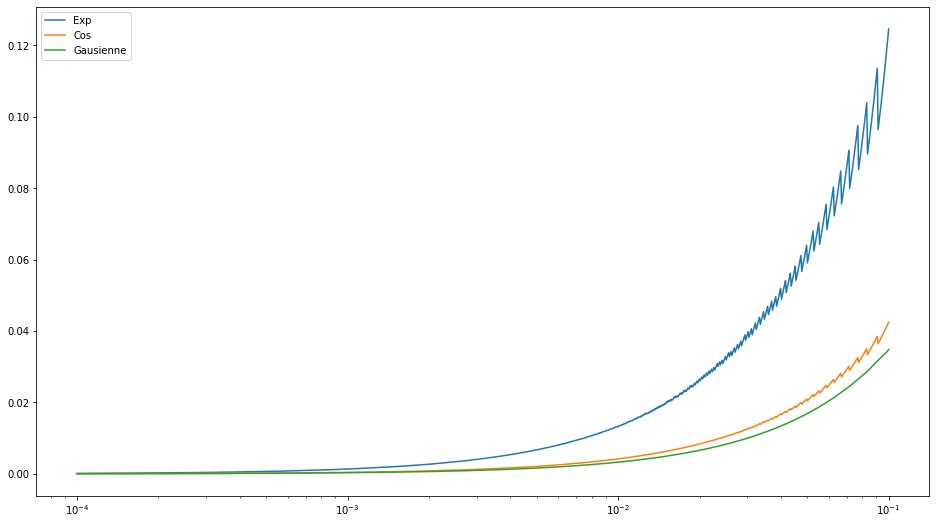

In [121]:
from math import log10

def evaluer_erreur(solveur, pb, dt):
    times, values = solveur(pb.eq, pb.x0, dt, pb.tf, pb.t0)
    erreur = []
    for (i,t) in enumerate(times):
        erreur.append(abs(pb.sol(t) - values[i]))
    return times, erreur

def evaluer_erreur_max(solveur, pb, dt):
    times, values = solveur(pb.eq, pb.x0, dt, pb.tf, pb.t0)
    erreur_max = 0
    for (i,t) in enumerate(times):
        erreur_max = max(erreur_max, abs(pb.sol(t) - values[i]))
    return erreur_max

def erreur_solveur(solveur, pb, dt_min, dt_max, points, log_scale = True):
    if log_scale:
        dt_min = log10(dt_min)
        dt_max = log10(dt_max)
    dts = np.linspace(dt_min, dt_max, points)
    error = []
    for (i, dt) in enumerate(dts):
        if log_scale:
            dt = 10**dt
        error.append(evaluer_erreur_max(solveur, pb, dt))
        dts[i] = dt
    return dts, error

def graph_erreur(solveur, pbs, dt_min, dt_max, points, log_scale = True):
    y_list = []
    name_list = []
    for pb in pbs:
        dts, error = erreur_solveur(solveur, pb, dt_min, dt_max, points, log_scale)
        y_list.append(error)
        name_list.append(pb.name)
    graph_multiple(dts, y_list, name_list, log_scale)
    
all_pbs = [PB_exp, PB_cos, PB_gss]
graph_erreur(solve_euler_explicit, all_pbs, 0.0001, 0.1, 1000)

On voit que les graphes des erreurs correspondent à des graphes de log en échelle logarithmique, on a bien une convergence d'ordre 1. On peut essayer de chercher un coefficient $\lambda$ tel que $erreur \leq \lambda dt$:

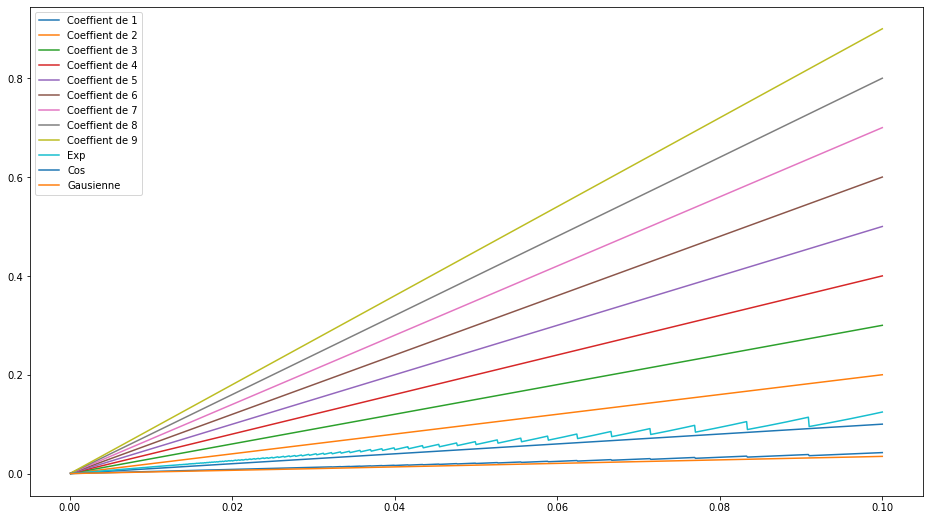

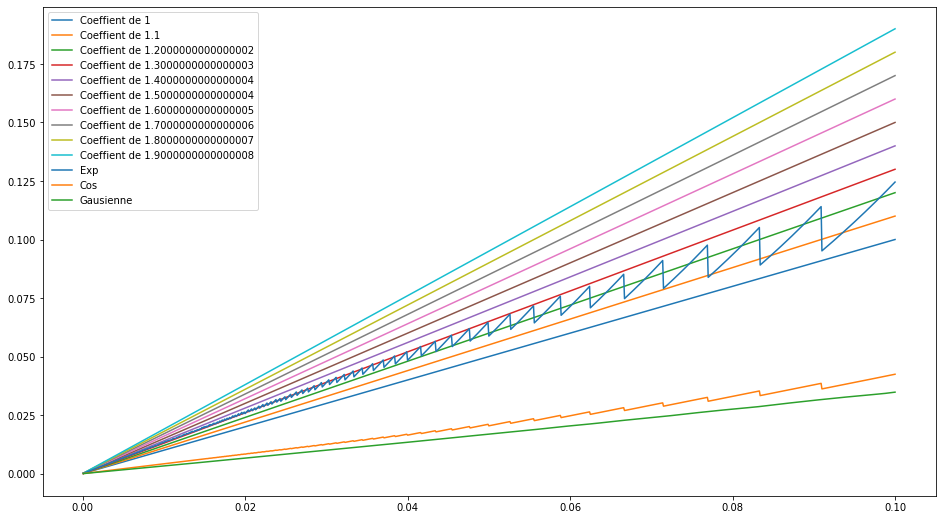

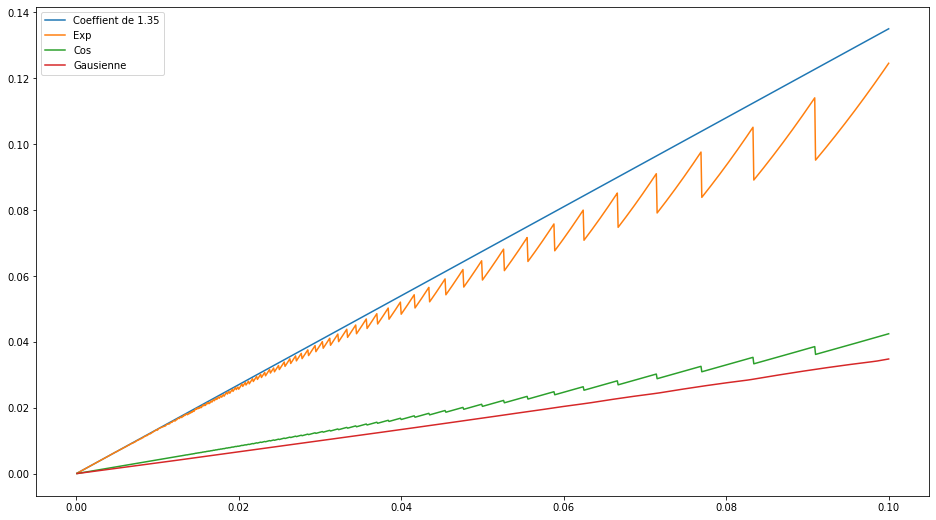

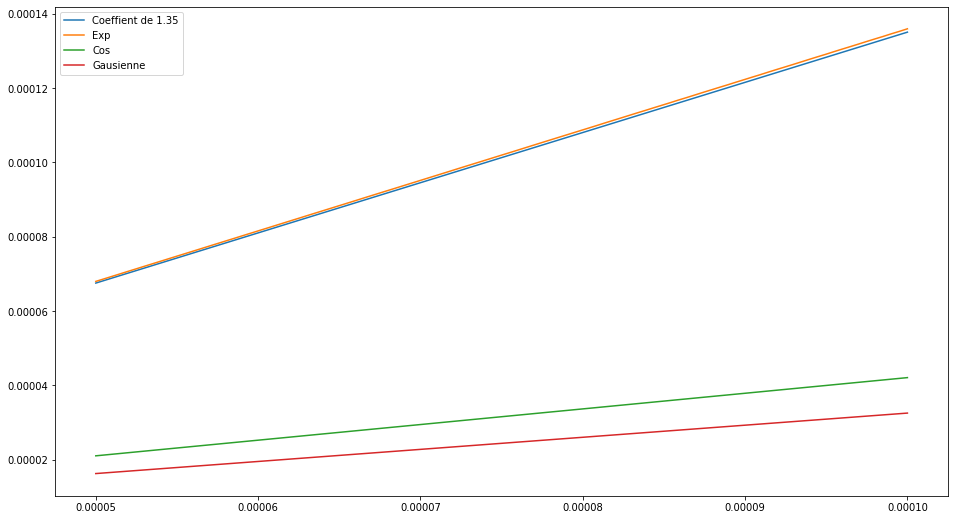

In [122]:
for i in range(1, 10):
    plt.plot([0.0001, 0.1], [0.0001 * i, 0.1 * i], label = 'Coeffient de '+ str(i))

graph_erreur(solve_euler_explicit, all_pbs, 0.0001, 0.1, 1000, log_scale = False)
plt.close()

for i in time_range(1, 2, 0.1):
    plt.plot([0.0001, 0.1], [0.0001 * i, 0.1 * i], label = 'Coeffient de '+ str(i))

graph_erreur(solve_euler_explicit, all_pbs, 0.0001, 0.1, 1000, log_scale = False)
plt.close()

plt.plot([0.0001, 0.1], [0.0001 * 1.35, 0.1 * 1.35], label = 'Coeffient de '+ str(1.35))
graph_erreur(solve_euler_explicit, all_pbs, 0.0001, 0.1, 1000, log_scale = False)
plt.close()

plt.plot([0.00005, 0.0001], [0.00005 * 1.35, 0.0001 * 1.35], label = 'Coeffient de '+ str(1.35))
graph_erreur(solve_euler_explicit, all_pbs, 0.00005, 0.0001, 100, log_scale = False)
plt.close()

Un coefficient de $1.35$ fait l'affaire pour le problème qui présente les plus grandes erreurs, ie l'exponentielle.

### Heun explicite

In [123]:
def solve_heun_explicit(f, x0, dt, tf, t0 = 0):
    '''Renvoie une aproximation de f entre t0 et tf évaluée à des temps séparées de dt. Utilise la méthode de Heun explicite.'''
    times = np.array([ t for t in time_range(t0, tf, dt)])
    n = times.shape[0]
    values = np.zeros((n, ))
    values[0] = x0
    demi_dt = dt / 2
    for i in range(1, n):
        fj = f(times[i - 1], values[i - 1])
        values[i] = values[i - 1] + demi_dt * (fj + f(times[i], values[i - 1] + dt * fj))
    return times, values

### Comparasion des schéma

On va comparer ce schéma au schéma précédent. Grâce à l'implémentation des fonctions de test comme non dépendantes du solveur, on à quasiment rien à modifier.

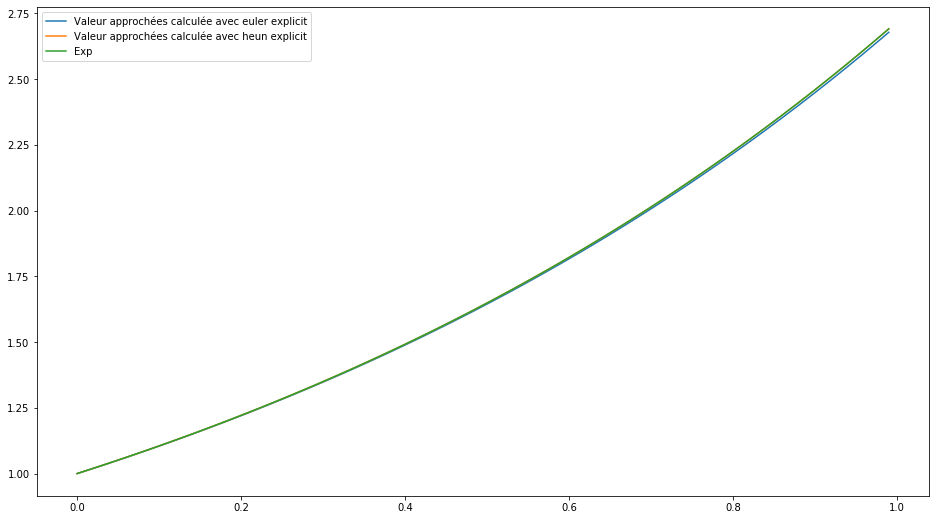

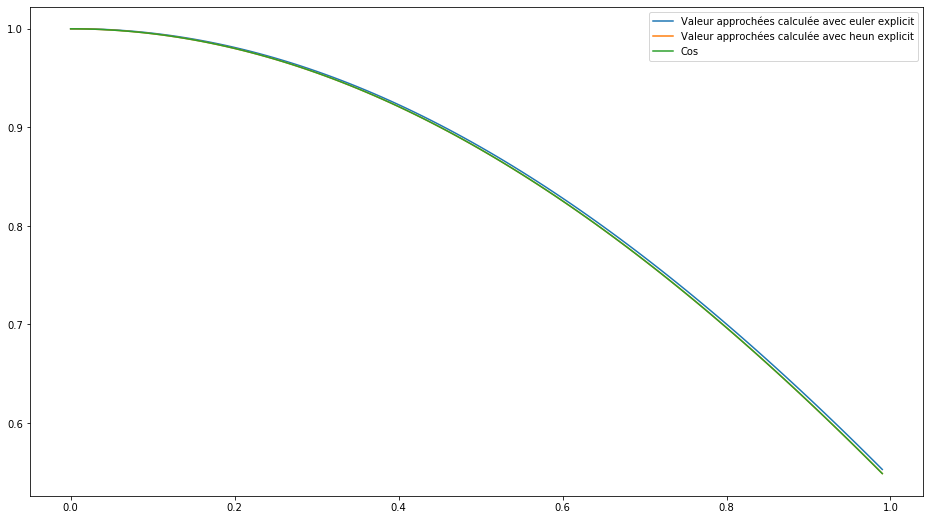

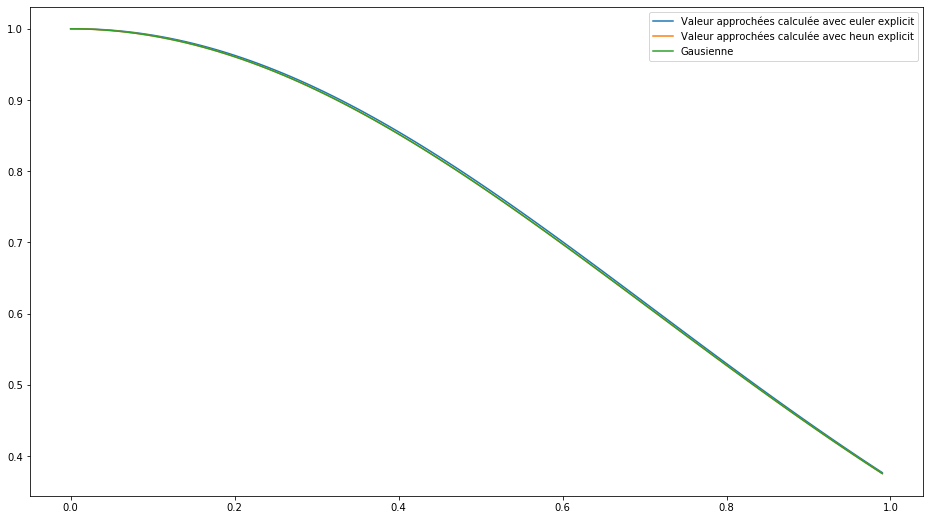

In [124]:
%matplotlib inline

def solveur_name(solveur):
    s = solveur.__name__.split('_')
    return s[1] + ' ' + s[2]

def test_solveurs(solveurs, pb, dt):
    y_list = []
    name_list = []
    for solveur in solveurs:
        times, values = solveur(pb.eq, pb.x0, dt, pb.tf, pb.t0)
        y_list.append(values)
        name_list.append('Valeur approchées calculée avec ' + solveur_name(solveur))
    true_values = []
    for t in times:
         true_values.append(pb.sol(t))
    y_list.append(true_values)
    name_list.append(pb.name)
    graph_multiple(times, y_list, name_list)
    
all_solveurs = [solve_euler_explicit, solve_heun_explicit]

test_solveurs(all_solveurs, PB_exp, 0.01)
test_solveurs(all_solveurs, PB_cos, 0.01)
test_solveurs(all_solveurs, PB_gss, 0.01)

Avec cette échelle, on n'arrive plus à différentier les courbes produites par Heun et celle qui est exacte. 
On va donc comparer les solveurs en étudiant leur erreurs respectives sur chaque problèmes.

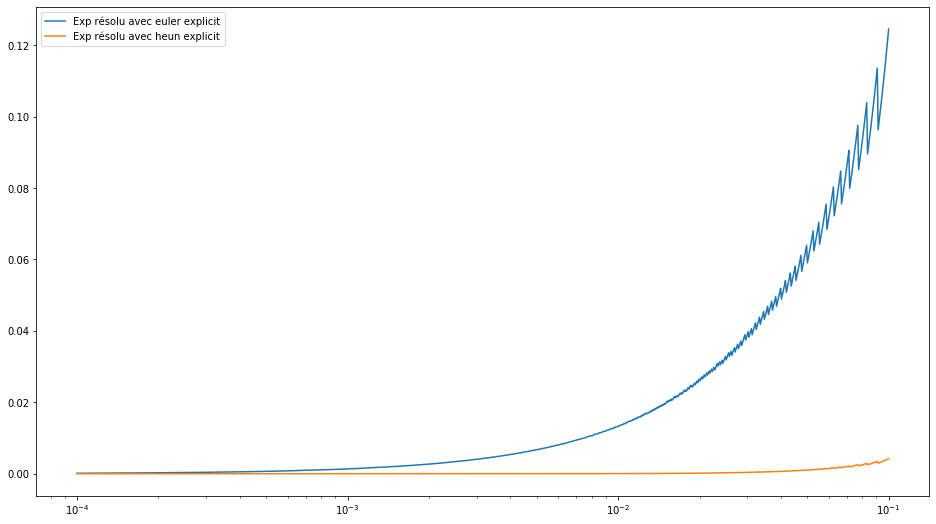

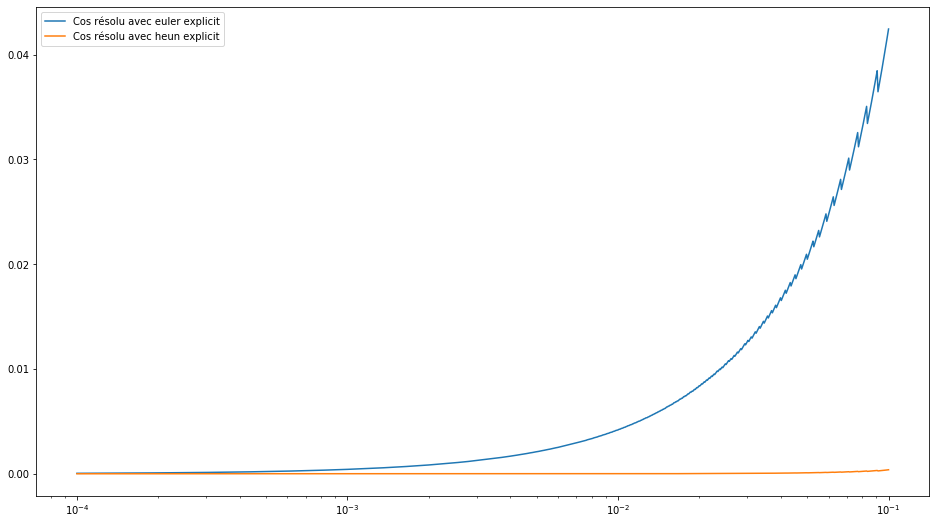

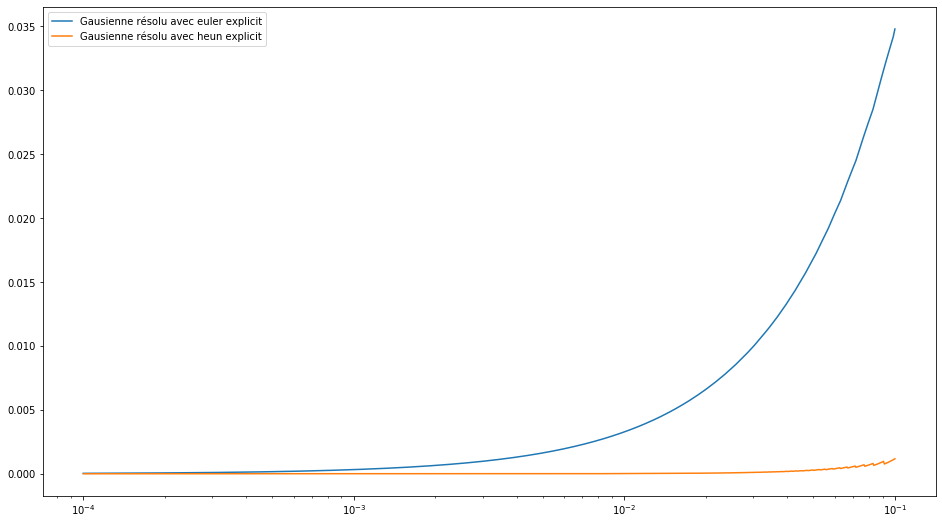

In [125]:
def graph_erreurs_solveurs(solveurs, pbs, dt_min, dt_max, points, log_scale = True):
    y_list = []
    name_list = []
    for solveur in solveurs:
        for pb in pbs:
            dts, error = erreur_solveur(solveur, pb, dt_min, dt_max, points, log_scale)
            y_list.append(error)
            name_list.append(pb.name + ' ' + 'résolu avec ' + solveur_name(solveur))
    graph_multiple(dts, y_list, name_list, log_scale)

graph_erreurs_solveurs(all_solveurs, [PB_exp], 0.0001, 0.1, 1000)
graph_erreurs_solveurs(all_solveurs, [PB_cos], 0.0001, 0.1, 1000)
graph_erreurs_solveurs(all_solveurs, [PB_gss], 0.0001, 0.1, 1000)

### La convergence d'ordre 2

On vérifie si Heun est bien un schéma d'ordre 2 avec le pire cas, l'exponentielle:

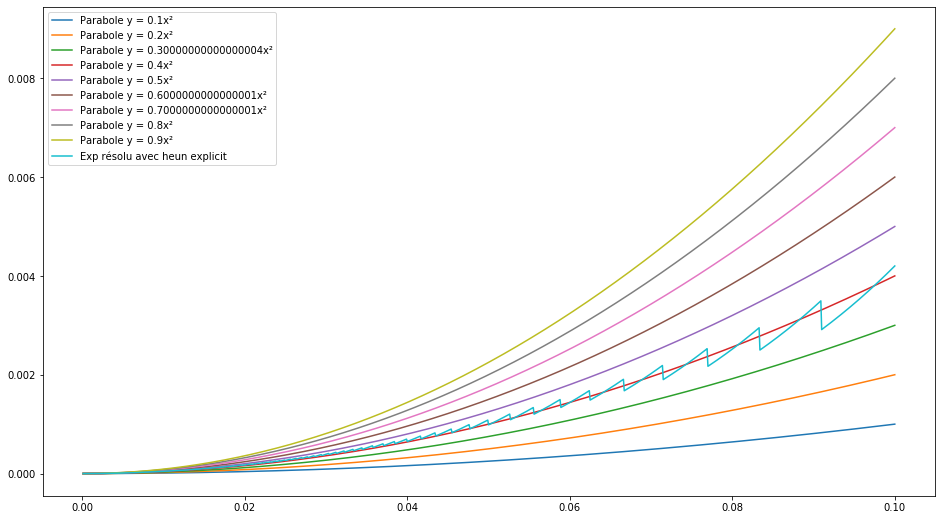

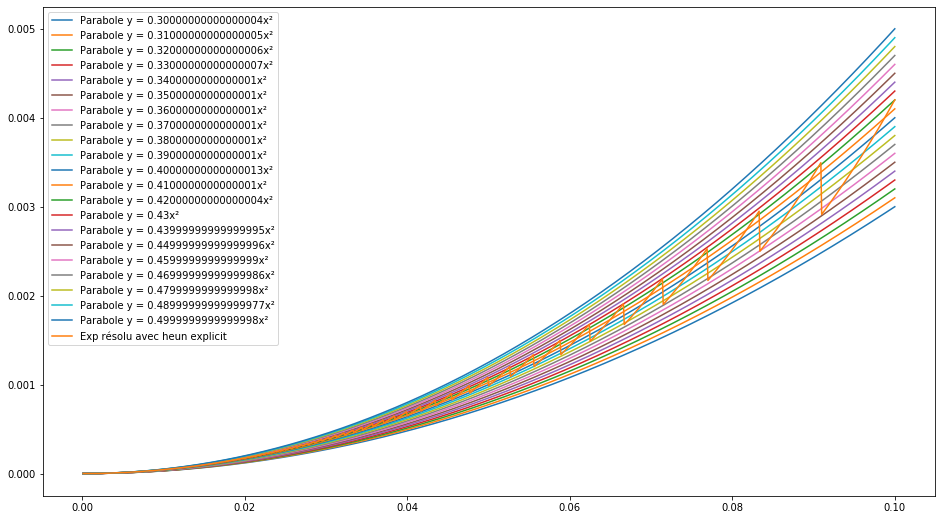

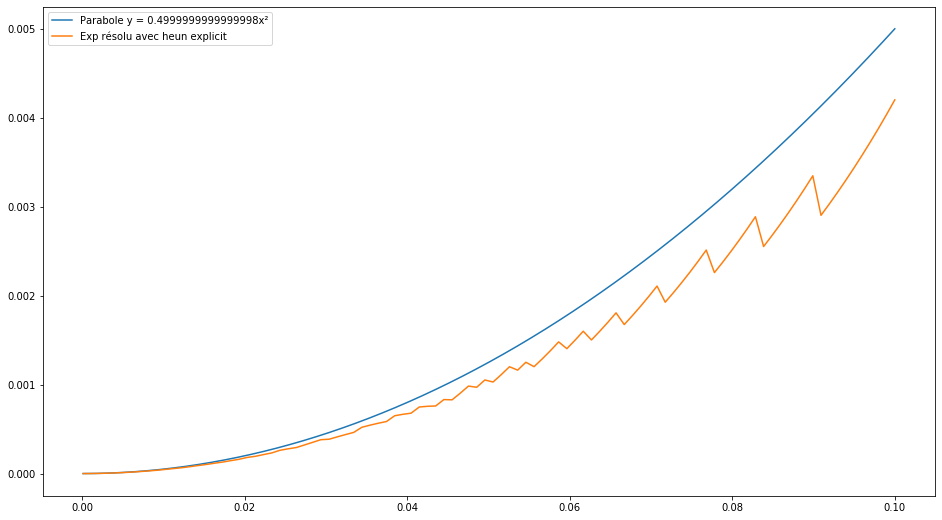

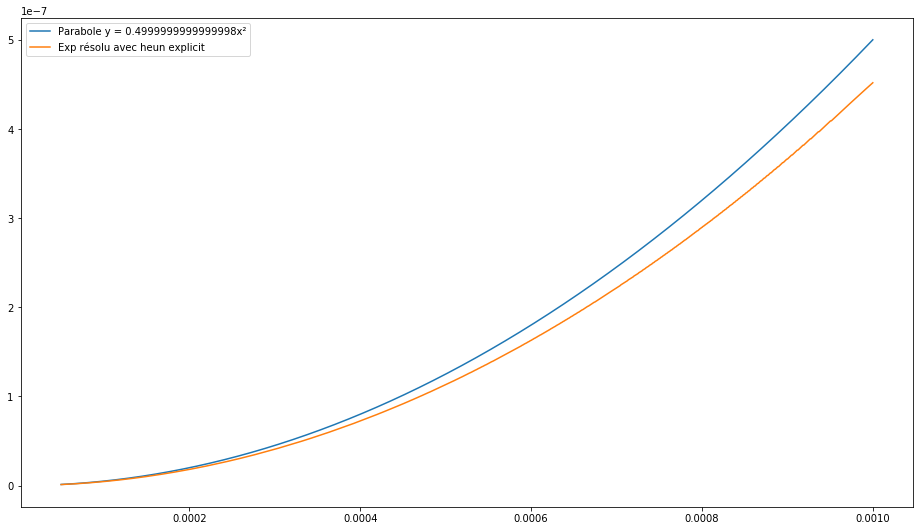

In [126]:
def plt_parabole(a, t0, tf):
    x = np.linspace(t0, tf, 10000)
    y = np.linspace(t0, tf, 10000)
    def f(x):
        return a*x*x
    y = np.vectorize(f)(y)
    plt.plot(x, y, label = 'Parabole y = ' + str(a) + 'x²')

for i in time_range(1, 10, 1):
    plt_parabole(i * 0.1, 0.0001, 0.1)
graph_erreurs_solveurs([solve_heun_explicit], [PB_exp], 0.0001, 0.1, 1000, log_scale = False)
plt.close()
    
for i in time_range(3, 5, 0.1):
    plt_parabole(i * 0.1, 0.0001, 0.1)
graph_erreurs_solveurs([solve_heun_explicit], [PB_exp], 0.0001, 0.1, 1000, log_scale = False)
plt.close()

plt_parabole(i * 0.1, 0.0001, 0.1)
graph_erreurs_solveurs([solve_heun_explicit], [PB_exp], 0.0001, 0.1, 100, log_scale = False)
plt.close()

plt_parabole(i * 0.1, 0.00005, 0.001)
graph_erreurs_solveurs([solve_heun_explicit], [PB_exp], 0.00005, 0.001, 1000, log_scale = False)
plt.close()

On a bien une convergence d'ordre 2 avec Heun explicite.

# Partie 2: Etude de l'erreur d'Euler explicite

### Etude de l'erreur locale

Pour alléger les notations, on a écrit $\Delta t$ au lieu de $\Delta t_{j}$. Cependant, il faut garder à l'idée que ce pas dépend de $j$, car c'est le principe même d'un pas adaptatif.

On calcule l'erreur locale avec la méthode d'Euleur explicite. On prend un temps $t_{j}$ et on suppose que $x_{j} = x(t_{j})$. L'erreur locale au temps $t_{j+1}$ est définie par:
\begin{equation}
e_{j+1} = x_{j+1} - x(t_{j+1})
\end{equation}

On pose la fonction:

\begin{equation}
F(t) = \int_{t}^{t_{j}} f(u, x(u)) du \nonumber
\end{equation}

On a donc une fonction $\mathcal{C}^{2}$, à laquelle on peut appliquer l'inégalité de Taylor-Young à l'ordre 2:

\begin{equation}
F(t_{j+1}) = F(t_{j}) + \Delta t \cdot x'(t_{j}) + \frac{\Delta t^{2}}{2} x''(t_{j}) + o(\Delta t^{2}) \nonumber
\end{equation}

\begin{equation}
x(t_{j+1}) - x(t_{j}) = 0 + \Delta t \cdot x'(t_{j}) + \frac{\Delta t^{2}}{2} x''(t_{j}) + o(\Delta t^{2}) \nonumber
\end{equation}

\begin{equation}
x_{j+1} - (x_{j} + \Delta t \cdot f(t_{j}, x(t_{j})) = \frac{\Delta t^{2}}{2} x''(t_{j}) + o(\Delta t^{2}) 
\end{equation}

\begin{equation}
e_{j+1} = \frac{\Delta t^{2}}{2} x''(t_{j}) + o(\Delta t^{2})
\end{equation}

On a donc établi que $e_{j+1} = \frac{\Delta t^{2}}{2} x''(t_{j}) + o(\Delta t^{2})$. On va maintenant utiliser la continuité de $f$. On pose $f_{j} = f(t_{j}, x_{j})$ :

\begin{align}
f(t_{j+1},  x_{j+1}) & = f(t_{j}+\Delta t,~x(t_{j}) + \Delta t \cdot f_{j}) \nonumber\\
& = f_{j} + \Delta t\cdot\partial_{t}f(t_{j}, x(t_{j})) + \Delta t \cdot f_{j} \cdot \partial_{x}f(t_{j}, x(t_{j})) + o(\sqrt{\Delta t^{2} + f_{j}^{2} \Delta t^{2}}) \nonumber\\
& = f_{j} + \Delta t[\partial_{t}f(t_{j}, x(t_{j})) + x'(t_{j})\partial_{x}f(t_{j}, x(t_{j}))] + o(\Delta t^{}) \nonumber\\
& = f_{j} + \Delta t \frac{d}{dt}(F')(t_{j}) + o(\Delta t^{}) \nonumber\\
& = f_{j} + \Delta t \frac{d}{dt}(x')(t_{j}) + o(\Delta t^{}) \nonumber\\
& = f_{j} + \Delta t x''(t_{j}) + o(\Delta t^{}) \nonumber
\end{align}

Et donc, il vient:

\begin{equation}
e_{j+1} = \frac{\Delta t}{2} \cdot (f(t_{j+1}, x_{j+1}) - f(t_{j}, x_{j}) + o(\Delta t^{})) \nonumber
\end{equation}

Ainsi:

\begin{equation}
\vert\vert e_{j+1} \vert\vert = \frac{\Delta t}{2} \vert\vert  f(t_{j+1}, x_{j+1}) - f(t_{j}, x_{j}) \vert\vert + o(\Delta t^{2}) \nonumber
\end{equation}

### Etablir le nouveau pas

On a déjà établi:
\begin{equation}
e_{j+1} = \frac{\Delta t^{2}}{2} x''(t_{j}) + o(\Delta t^{2})
\end{equation}

En divisant par $\Delta t^{2}$ et en passant à la limite $\Delta t \longrightarrow 0^{+}$ il vient:

\begin{equation}
\lim_{\Delta t \longrightarrow 0^{+}} e_{j+1} = x''(t_{j})
\end{equation}

Et ainsi on a bien $e_{j+1} = O(\Delta t^{2})$. 

On peut donc faire une approximation de $e_{j+1}$ au premier ordre avec $\vert\vert e_{j+1}\vert\vert = k \Delta t^{2}$ (encore une fois, $k$ dépend de $j$ mais on allège un peu les notations). Dans le but de respecter la condition $\vert\vert e_{j+1} \vert\vert \leq Tol_{abs}$, on va chercher un nouveau pas $\Delta t_{new}$:

\begin{equation}
\vert\vert e_{j+1} \vert\vert = k \Delta t^{2}
\end{equation}
\begin{equation}
k =  \frac{\vert\vert e_{j+1} \vert\vert}{ \Delta t^{2}}
\end{equation}

On suppose qu'on a $\Delta t_{new}$ tel que $\vert\vert e_{j+1} \vert\vert \leq Tol_{abs}$, on va en déduire une condition sur $\Delta t_{new}$:

\begin{equation}
\vert\vert e_{j+1} \vert\vert \leq Tol_{abs}
\end{equation}
\begin{equation}
k \Delta t^{2}_{new} \leq Tol_{abs}
\end{equation}
\begin{equation}
\Delta t^{2}_{new} \leq \frac{Tol_{abs}}{k}
\end{equation}
\begin{equation}
\Delta t^{2}_{new} \leq \frac{Tol_{abs}}{\frac{\vert\vert e_{j+1} \vert\vert}{ \Delta t^{2}}}
\end{equation}
\begin{equation}
\Delta t^{2}_{new} \leq  \Delta t^{2} \frac{Tol_{abs}}{\vert\vert e_{j+1} \vert\vert}
\end{equation}
\begin{equation}
\Delta t^{}_{new} \leq  \Delta t^{} \sqrt{\frac{Tol_{abs}}{\vert\vert e_{j+1} \vert\vert}}
\end{equation}

Cette approche nous suggère $\Delta t_{new}$ comme pas optimal.

### Solveur à pas variable

Ce solveur utilise la méthode d'Euler à pas variable pour renvoyer une approximation de $x$ la solution de $x'(t) = f(t, x)$ aux points $t_{0}$, $t_{0} + dt_{max}$, $t_{0} + 2dt_{max}$,...  

Pour illustrer le fonctionnement de ce solveur, on suppose d'abord que le point $x_{j}$ a été tracé au temps $t_{j}$. Pour tracer le point $x_{j+1}$ à l'abscisse $t_{j} + dt_{max}$, on va utiliser la même approche que dans la méthode d'Euler explicite, mais plusieurs fois. 

On commence par calculer $x_{next} = x_{j} + dt \cdot f(t_{j}, x_{j})$, comme dans Euler à pas constant. Ensuite, on calcule $x_{back} = x_{next} - dt \cdot f(t_{j + dt}, x_{next})$: c'est encore le même principe que la méthode d'Euler, mais cette fois on va dans le sens des abscisses décroissants. Si cette méthode était exacte, on aurait $x_{j} = x_{back}$. Pour estimer l'erreur de la méthode, on va donc utilser la quantité $\frac{\vert x_{j} - x_{back} \vert}{2}$. Cette quantité est liée aux variations de la fonction $x$ car elle est calculée grâce à $f$, donc $x'$. Si cette quantité est plus grande qu'un seuil $Tol$ qu'on passe en argument à la fonction solveur, alors le rapport $r = \frac{Tol}{\frac{\vert x_{j} - x_{back} \vert}{2}} = \frac{2 Tol}{\vert x_{j} - x_{back} \vert}$ est inférieur à $1$. Sinon, $r$ est supérieur à $1$.

C'est ce rapport qui va permettre d'adapter le pas, en utilisant comme nouveau pas à la prochaine étape $0.9 * dt \sqrt{r}$. Ce choix est motivé par la formule que l'on a établie à la sous-partie précédente, avec un facteur de $0.9$ pour assurer une petite marge de tolérance. Si $r \leq 1$, alors l'erreur que l'on commet est trop grande: il faut donc prendre un pas plus petit à la prochaine approximation, ce que l'on fait en multipliant $dt$ par $\sqrt{r}$. En revanche, si $r \geq 1$, cela veut dire que la fonction n'est pas en train de beaucoup varier (car plus $r$ est grand, plus la fonction varie entre les abscisses $t_{j}$ et $t_{j} + dt$) et on peut se permettre de prendre un pas plus grand, ce qui est le cas puisque l'on multiplie $dt$ par $\sqrt{r}$. On est maintenant au temps $t_{new} = t_{j} + dt$ avec un nouveau pas $dt_{new}$ et une approximation $x_{new}$ de $x$ à $t_{new}$. On ne note pour l'instant aucune valeur dans le tableau des valeurs que l'on renverra.

On continue ce procédé à partir de $t_{new}$ jusqu'à ce que:
 - $dt$ tombe en dessous de $dt_{min}$, ce qui veux dire que malgré la réduction de pas, l'erreur reste trop grande. On arrête donc le processus et on renvoie une erreur.
 - $dt$ dépasse la moitié de $dt_{max}$, auquel cas on remet $dt$ à $\frac{dt_{max}}{2}$ pour ne pas calculer $x_{j+1}$ en trop peu d'étapes. On continue quand même le procédé.
 - le temps $t_{new}$ auquel on travaille est plus grand que $dt_{max}$, auquel cas on arrête le processus et on 'revient' en arrière en utilisant le schéma d'Euler:
\begin{equation}
x_{j+1} = x_{new} - (t_{new} - (t_{j} + dt_{max})) * f(t_{new}, x_{new})
\end{equation}


On a donc bien une nouvelle approximation $x_{j+1}$ de $x$ à $t_{j+1}$.

Ce que l'on peut reprocher à ce solveur, c'est de constater qu'une erreur trop grande a été commise en calculant $x_{new}$ sans la corriger: en effet, si l'on remarque une erreur trop grande, on adapte le pas réduire les futures erreures, mais le calcul de $x_{new}$ est déjà fini. On pourrait peut-être refaire ce calcul, mais cela prendrai plus de temps, et il y a toujours le risque d'être coincé à un temps $t_{new}$ où malgré le fait que l'on diminue le pas, l'erreur reste supérieure au seuil de tolérance.

On va maintenant réécrire ce programme pour qu'il soit plus clair, mais malheureusement moins compact.

In [3]:
def solve_ivp_euler_explicit_variable_step(f, t0, x0, t_f, dtmin = 1e-16, dtmax = 0.01, atol = 1e-6):
    dt = dtmax/10; # initial integration step
    ts, xs = [t0], [x0]  # storage variables
    t = t0
    ti = 0  # internal time keeping track of time since latest storage point : must remain below dtmax
    x = x0
    while ts[-1] < t_f:
        while ti < dtmax:
            t_next, ti_next, x_next = t + dt, ti + dt, x + dt * f(x)
            x_back = x_next - dt * f(x_next)
            ratio_abs_error = atol / (linalg.norm(x_back-x)/2)
            dt = 0.9 * dt * sqrt(ratio_abs_error)
            if dt < dtmin:
                raise ValueError("Time step below minimum")
            elif dt > dtmax/2:
                dt = dtmax/2
            t, ti, x = t_next, ti_next, x_next
        dt2DT = dtmax - ti # time left to dtmax
        t_next, ti_next, x_next = t + dt2DT, 0, x + dt2DT * f(x)
        ts = vstack([ts,t_next])
        xs = vstack([xs,x_next])
        t, ti, x = t_next, ti_next, x_next
    return (ts, xs.T)


##On va réecrire ce programme sans en modifier le fonctionnement (on change le nom de 2 variables et on ajoute des commentaires)


def solve_ivp_euler_explicit_variable_step(f, t0, x0, t_f, dtmin = 1e-16, dtmax = 0.01, atol = 1e-6):
    dt = dtmax/10; # dt par défaut
    vecteur_temps, vecteur_valeurs = [t0], [x0]  # vecteurs de temps et de valeurs que l'on renverra
    t = t0 #temps de travail, qu'on initialise à t0
    ti = 0  # distance au dernier temps où l'on a fait une approximation
    x = x0 #abscisse de travail, intialisée à x0
    while ts[-1] < t_f:
        """tant que la dernière approximation est faite à un temps qui précède tf, on continue de calculer des approximations
        dtmax plus loin"""
        while ti < dtmax:
            """tant que le temps de travail est inférieur à dtmax"""
            t_next =  t + dt #on calcule le prochain temps de travail
            ti_next = ti + dt #on calcule quelle sera le temps écoulé depuis la dernière approximation losque l'on sera à t_next
            x_next = x + dt * f(x) #calcul de x_next
            x_back = x_next - dt * f(x_next) #calcul de x_back
            ratio_abs_error = atol / (linalg.norm(x_back-x)/2) #calcul de r
            dt = 0.9 * dt * sqrt(ratio_abs_error) #calcul du nouveau dt
            if dt < dtmin:
                raise ValueError("Time step below minimum") #premier cas que l'on a évoqué
            elif dt > dtmax/2:
                dt = dtmax/2 #deuxième cas que l'on a évoqué
            t, ti, x = t_next, ti_next, x_next 
            """on met à jour le temps de travail, le temps depuis la dernière approximation et l'abscissse de travail"""
        dt2DT = dtmax - ti # différence de temps entre le temps de travail et le temps où l'on doit faire l'approximation (<0)
        t_next = t + dt2DT #on va ramèner le temps de travail au temps de l'approximation
        ti_next = 0 #on va remettre la distance entre le temps de travail et le temps de la dernière approximation à 0
        x_next = x + dt2DT * f(x) #on calcule la nouvelle approximation
        vecteur_temps = vstack([vecteur_temps,t_next]) #on note le temps de cette nouvelle approximation dans le vecteur des temps
        vecteur_valeurs = vstack([vecteur_valeurs,x_next]) #on note l'approximation dans le vecteur des valeurs
        t, ti, x = t_next, ti_next, x_next #on met a jours les variables de travail
    return (ts, xs.T)